<a href="https://colab.research.google.com/github/yexf308/AppliedStatistics/blob/main/9_Decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline 
import pandas as pd
from scipy import linalg
from itertools import combinations
import scipy

Populating the interactive namespace from numpy and matplotlib


$\def\m#1{\mathbf{#1}}$
$\def\mm#1{\boldsymbol{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
$\def\mr#1{\mathrm{#1}}$
$\newenvironment{rmat}{\left[\begin{array}{rrrrrrrrrrrrr}}{\end{array}\right]}$
$\newcommand\brm{\begin{rmat}}$
$\newcommand\erm{\end{rmat}}$
$\newenvironment{cmat}{\left[\begin{array}{ccccccccc}}{\end{array}\right]}$
$\newcommand\bcm{\begin{cmat}}$
$\newcommand\ecm{\end{cmat}}$


# Decision tree 
- Defined by a hierarchy of rules (in form of a tree).

- Rules form the internal nodes. Each rule (internal node) tests the value of some property (feature) of the data.

- **root**: topmost internal node and **leaf**: decision node at the ends

- **decision tree learning:** training data is used to construct/fit the decision tree model. Then the trained decision tree is used to predict for new input.

- **Advantage**: easy to interprete and quick prediction.

<img src="https://github.com/yexf308/MAT592/blob/main/image/DT3.png?raw=true" width="500" />



## Toy examples

### Example 1: Blue vs Green

<img src="https://github.com/yexf308/MAT592/blob/main/image/DT1.png?raw=true" width="900" />

- **Right:** Classification: 2-D points in blue vs. green region with 2 features
$(x_1, x_2)$.

- **Left**: The following decision tree is used to predict the region (blue/green) of a
new point in the order defined by the tree ( first $x_2$ and then $x_1$) This is also called **regression tree**.



The first node asks if $x_1$ is greater than
some threshold $t_1$. If yes, we then ask if $x_2$ is greater than some other threshold $t_2$. If yes, we enter the
bottom left leaf node. This corresponds to the region of space defined by
$R_1=\{\mathbf{x}: x_1\ge t_1, x_2\ge t_2\}$. The overall result is that we partition the 2d input space into 4 regions. By using enough splits (i.e., deep enough trees), we can make a piecewise linear approximationt to decision boundaries with more complex shapes, but it may require a lot of data to fit such a model.

The output for $R_1$ can be estimated using (if $y$ is continuous output as well) 
\begin{align}
w_1 = \frac{\sum_{i=1}^Ny^{(i)}\mathbb{1}_{\mathbf{x}^{(i)}\in R_1} }{\sum_{i=1}^N \mathbb{1}_{\mathbf{x}^{(i)}\in R_1}}
\end{align}

Formally, the regression tree is defined by
\begin{align}
f(\mathbf{x}; \theta) = \sum_{j=1}^Jw_j \mathbb{1}_{\mathbf{x}\in R_j}
\end{align}
where $R_j$ is the region specified by the $j$’th leaf node, $w_j$ is the predicted output for that node, $J$ is the number of nodes. So the parameter is $\theta=\{(R_j, w_j)\}_{j=1}^J$. 


### Example 2: Tennis

<img src="https://github.com/yexf308/MAT592/blob/main/image/DT.png?raw=true" width="900" />

- Decide whether to play or not to play Tennis based on 4 features:
outlook, temperature, humidity, wind. 

  For categorical inputs, we can define the splits based
on comparing feature to each of the possible values for that feature, like "outlook" having three possible value, 'sunny', 'overcase' and 'rain'.

- **Question:** why does it make more sense to test the "outlook"
feature  first? "Temperature" is completely ignored? 
   - Because "outlook" is the most informative of all the 4 features and "temperature" is not informative. 
   
   - We need to quantify the informativeness. 

## Decision tree construction

- Data comes in records of the form $\{\mathbf{x}^{(i)}, y^{(i)}\}_{i=1}^N$, the vector $\mathbf{x}$ is composed of **the features variables**, $x_1, x_2, x_3$, can be continuous or discrete. The dependent variable $y$, is the **target variable** that we are trying to understand, classify or generalize. 

- We use training data $\{\mathbf{x}^{(i)}, y^{(i)}\}_{i=1}^N$ to construct the decision tree. Each internal node corresponds to a rule to test some feature. 


- To fit the model, we have the loss function 
$$ \mathcal{L}(\theta)=\sum_{i=1}^N\ell(y^{(i)}, f(\mathbf{x}^{(i)};\theta)) =\sum_{j=1}^J \sum_{\mathbf{x}^{(i)}\in R_j}\ell(y^{(i)},w_j)$$
 Unfortunately, this is not differentiable, because of the need to learn the discrete tree structure.
 
- **Idea:** Use a greedy procedure, in which we iteratively grow the tree one node at a time.
Highly informative features are placed higher up in the tree;
will need a way to rank features according to their information
content. 

We will introduce three decision tree algorithms: **Iterative Dichotomiser 3(ID3)**, **C4.5** and **Classification and regression trees (CART)**.

# Algorithm 1: Iterative Dichotomiser 3
In ID3, we will use **entropy** and **information gain** as the criteria/metric for ranking. All features are **categorical/discrete** features and the output are binary($+$ or $-$).  


## Theory
### Entropy

- Entropy (in information theory) measures the
randomness/uncertainty in the data

- Given a set of $\mathcal{S}$ with $k$ classes, associated with a Multinomial probability distribution $\mathbf{p}=(p_1, \dots, p_k)$ with $\sum_{i}p_i =1$.

- Entropy is defined as follows 
  $$ H(\mathcal{S}) = -\sum_{i=1}^k p_i\log_2 p_i$$
  Note the logarithm is base 2 instead of base $e$.

  Example: for $k=2$, $\mathcal{S}_1$ with $\mathbf{p}=(1/2, 1/2)$; $\mathcal{S}_2$ with $\mathbf{p}=(0.3, 0.7)$. Then $H(\mathcal{S}_1)=1$ and $H(\mathcal{S}_2)=-0.3\log_2(0.3)-0.7\log_2(0.7)\approx 0.8816$.

**Property:** 

- $0\le H(\mathcal{S})\le \log_2(k)$. The minimum is reached when $p_i=1$ for some class $i$ (no uncertainty, since all instances are from the same class). The maximum is reached when $p_i=\frac{1}{k}$ for all classes
(uniform distribution).

- In general, 

  Dominant/skewed classes $\rightarrow$ Low entropy/uncertainty.      
  
  Equi-probable classes $\rightarrow$ High entropy/uncertainty.

### Information gain

- **Information gain (IG)** of set $\mathcal{S}$ on some feature $F$ is
$$ \text{IG}(\mathcal{S}; F)= H(\mathcal{S})- H(\mathcal{S}|F)$$
  where $H(\mathcal{S}|F)$ is conditional entropy of $\mathcal{S}$ given the value of feature $F$. 

- $\text{IG}(\mathcal{S}; F)$ measures the decrease in uncertainty about $\mathcal{S}$ once the value of feature $F$ is known.


- Specifically, conditional entropy of $\mathcal{S}$ on $F$ is computed by
$$ H(\mathcal{S}|F) = \sum_{f\in F} P(F=f)H(\mathcal{S}_f)=\sum_{f\in F} \frac{|\mathcal{S}_f|}{|\mathcal{S}|}H(\mathcal{S}_f)$$
  where $\mathcal{S}_f$ is the subset of $\mathcal{S}$ with feature $F$ having value $f$, $ |\cdot|$ denotes the number of elem of a set.


### Computing information gain: Tennis

- $\mathcal{S}=\{1, \dots, 14\}$, with 9 "play" and 5 "no-play". Then 
   $$H(\mathcal{S})= -(9/14)\log_2(9/14)-(5/14)\log_2(5/14)\approx 0.94 $$

- Consider the feature $F=$wind. Then $f\in\{\text{strong}, \text{weak}\}$. 
$$\mathcal{S}_{\text{strong}} = \{2,6,7,11,12,14\}, \ \text{play}=\{3+, 3-\}, \ H(\mathcal{S}_{\text{strong}})=1 $$

$$\mathcal{S}_{\text{weak}} = \{1,3,4,5,8,9,10,13\}, \ \text{play}=\{6+, 2-\}, \ H(\mathcal{S}_{\text{weak}})\approx 0.811 $$

- information gain on the feature "wind":
\begin{align}
 \text{IG}(\mathcal{S},\text{wind})&= H(\mathcal{S}) - H(\mathcal{S}|\text{wind}) \\
 &= H(\mathcal{S}) -\frac{|\mathcal{S}_{\text{weak}}|}{|\mathcal{S}|}H(\mathcal{S}_{\text{weak}}) -\frac{|\mathcal{S}_{\text{strong}}|}{|\mathcal{S}|}H(\mathcal{S}_{\text{strong}}) \\
 & =0.94 -8/14\cdot0.811 - 6/14 \cdot 1=0.048
\end{align}


- Similarly, 
\begin{align}
&\text{IG}(\mathcal{S},\text{outlook}) = 0.246 \\ 
&\text{IG}(\mathcal{S},\text{humidity}) = 0.151 \\ 
&\text{IG}(\mathcal{S},\text{temperature)}) = 0.029
\end{align}

- '"outlook" has most IG: chosen as the first feature to test
(root node)


<img src="https://github.com/yexf308/MAT592/blob/main/image/tennis.png?raw=true" width="300" />
<img src="https://github.com/yexf308/MAT592/blob/main/image/tennis2.png?raw=true" width="400" />


### Grow the tree

Iteratively select the feature with highest IG for each child node to
grow the tree. 

For **left node:**
-  $\mathcal{S}=\{1,2,8,9,11\}$ with play=$\{2+, 3-\}$, 
$$H(\mathcal{S}) = -(2/5)\log_2(2/5)-(3/5)\log_2(3/5)\approx 0.97$$

- for the feature "temperature":
  - $\mathcal{S}_{\text{hot}} = \{1,2\}$ with play=$\{0+, 2-\}$, $H(\mathcal{S}_{\text{hot}})=0$.

  - $\mathcal{S}_{\text{mild}} = \{8,11\}$ with play=$\{1+, 1-\}$, $H(\mathcal{S}_{\text{mild}})=1$.

  - $\mathcal{S}_{\text{cool}} = \{9\}$ with play=$\{1+, 0-\}$, $H(\mathcal{S}_{\text{cool}})=0$.


- information gain on the feature "temperature": 
\begin{align} 
\text{IG}(\mathcal{S}, \text{temp}) &= H(\mathcal{S})-H(\mathcal{S}|\text{temp}) \\
&=H(\mathcal{S}) -\frac{|\mathcal{S}_{\text{hot}}|}{|\mathcal{S}|}H(\mathcal{S}_{\text{hot}}) -\frac{|\mathcal{S}_{\text{mild}}|}{|\mathcal{S}|}H(\mathcal{S}_{\text{mild}}) -\frac{|\mathcal{S}_{\text{cool}}|}{|\mathcal{S}|}H(\mathcal{S}_{\text{cool}}) \\ 
&=0.97-2/5\cdot 0 - 2/5\cdot 1 - 1/5\cdot 0= 0.57
\end{align}

- Similarly, 
 $$ \text{IG}(\mathcal{S}, \text{humidity})=0.97 $$
 $$  \text{IG}(\mathcal{S}, \text{wind})=0.019$$
 Choose feature "humidity" for the left node.



For **middle node:**
 - $\mathcal{S}=\{3,7,12,13\}$ with play=\{4+, 0-\}: no
need to grow due to identical labels ($H(\mathcal{S})=0$) 
 
For **right node:**
 
 - Compute IG for each feature except for
"outlook", choose "wind" since it has the highest IG.

End up with a decision tree perfectly fitting the training data

For **Stopping criteria**: stop expanding a node further when
  - all training examples have the same label
  - run out of features to test (leading to a training error)


### ID3 algorithm
**Iterative Dichotomiser 3(ID3)**: 

- Compute the entropy for dataset

- For every feature:
  - calculate entropy for all categorical values
  - take average information entropy for the current feature
  - calculate gain for the current feature
- Pick the highest gain feature.

- Repeat until we get the tree we desired.  

## Implementation

In [2]:
eps  = 10**-12
outlook = 'sunny,sunny,overcast,rainy,rainy,rainy,overcast,sunny,sunny,rainy,sunny,overcast,overcast,rainy'.split(',')
temp = 'hot,hot,hot,mild,cool,cool,cool,mild,cool,mild,mild,mild,hot,mild'.split(',')
humidity = 'high,high,high,high,normal,normal,normal,high,normal,normal,normal,high,normal,high'.split(',')
windy = 'weak,strong,weak,weak,weak,strong,strong,weak,weak,weak,strong,strong,weak,strong'.split(',')
play = 'no,no,yes,yes,yes,no,yes,no,yes,yes,yes,yes,yes,no'.split(',')

dataset ={'outlook':outlook,'temp':temp,'humidity':humidity,'windy':windy,'play':play}
df = pd.DataFrame(dataset,columns=['outlook','temp','humidity','windy','play'])
df



,outlook,temp,humidity,windy,play
0,sunny,hot,high,weak,no
1,sunny,hot,high,strong,no
2,overcast,hot,high,weak,yes
3,rainy,mild,high,weak,yes
4,rainy,cool,normal,weak,yes
5,rainy,cool,normal,strong,no
6,overcast,cool,normal,strong,yes
7,sunny,mild,high,weak,no
8,sunny,cool,normal,weak,yes
9,rainy,mild,normal,weak,yes


In [3]:
df.loc[0]

outlook     sunny
temp          hot
humidity     high
windy        weak
play           no
Name: 0, dtype: object

In [4]:
df[df['outlook']=='sunny'].reset_index(drop=True)

,outlook,temp,humidity,windy,play
0,sunny,hot,high,weak,no
1,sunny,hot,high,strong,no
2,sunny,mild,high,weak,no
3,sunny,cool,normal,weak,yes
4,sunny,mild,normal,strong,yes


In [5]:
#step 1: Compute the entropy for data-set

def entropy(df): #H(S)
    target = df.keys()[-1] 
    entropy_data = 0
    target_values = df[target].unique() #yes or no
    for target_value in target_values:
        fraction = df[target].value_counts()[target_value]/len(df[target])
        entropy_data += -fraction*np.log2(fraction)
    return entropy_data

print('entropy for the data set is',entropy(df) )   

entropy for the data set is 0.9402859586706309


In [6]:
# define a function ent to calculate conditional entropy of each feature
def entropy_feature(df,feature): #H(S|F)
    target = df.keys()[-1] 
    target_values = df[target].unique()  #This gives all 'Yes' and 'No'
    variables = df[feature].unique()    #This gives different features (f values)

    entropy = 0
    for variable in variables:
        entropy_each_feature = 0
        for target_variable in target_values:
            num = len(df[feature][df[feature]==variable][df[target] ==target_variable]) #numerator
            den = len(df[feature][df[feature]==variable])  #denominator
            fraction = num/(den+eps)  #+eps can prevent runtime error of divide 0. 
            entropy_each_feature += -fraction*log2(fraction+eps) #This calculates entropy for one feature   H(S_f)
        fraction2 = den/len(df) # P(F=f)
        entropy += -fraction2*entropy_each_feature   #Sums up all the entropy, H(S|F)=\sum P(F=f) H(S_f)

    return(abs(entropy))


In [7]:
print('features are', df.keys()[:-1])
entropy_feature_list = {k:entropy_feature(df,k) for k in df.keys()[:-1]}
print('entropy of each feature is', entropy_feature_list)

entropy_feature_list['temp']

features are Index(['outlook', 'temp', 'humidity', 'windy'], dtype='object')
entropy of each feature is {'outlook': 0.6935361388938892, 'temp': 0.9110633930089052, 'humidity': 0.7884504573054976, 'windy': 0.8921589282595528}


0.9110633930089052

In [8]:
# calculate Info gain of each feature 
def ig(df):
    IG = []
    for feature in df.keys()[:-1]:
      IG.append(entropy(df)-entropy_feature(df,feature))
    return IG  


print('IG of each feature is', ig(df))

IG of each feature is [0.2467498197767417, 0.029222565661725763, 0.15183550136513335, 0.04812703041107813]


In [9]:

def get_subtable(df, node,variable):
  return df[df[node] == variable].reset_index(drop=True)


def buildTree(df,tree=None): 
    target = df.keys()[-1]   #To make the code generic, changing target variable class name
    features = df.keys()[:-1]
    #Here we build our decision tree

    #Get feature with maximum information gain
    IG = ig(df)
    node = features[argmax(IG)]
    
    #Get distinct value of that feature
    variables = df[node].unique()
    
    #Create an empty dictionary to create tree    
    if tree is None:                    
        tree={}
        tree[node] = {}
    
   #We make loop to construct a tree by calling this function recursively. 
    #In this we check if the subset is pure and stops if it is pure. 

    for variable in variables:
        
        subtable = get_subtable(df,node,variable)
        clValue,counts = unique(subtable[target],return_counts=True)                        
        
        if len(counts)==1:#Checking purity of subset
            tree[node][variable] = clValue[0]                                                    
        else:        
            tree[node][variable] = buildTree(subtable) #Calling the function recursively 
                   
    return tree
  
  


In [10]:
import pprint
t=buildTree(df)
pprint.pprint(t)

{'outlook': {'overcast': 'yes',
             'rainy': {'windy': {'strong': 'no', 'weak': 'yes'}},
             'sunny': {'humidity': {'high': 'no', 'normal': 'yes'}}}}


In [11]:
# let's perturb this dataset.
df1=df.append(pd.DataFrame([['sunny','hot','normal','strong','no']], columns=['outlook','temp','humidity','windy','play']),ignore_index=True)
df1

,outlook,temp,humidity,windy,play
0,sunny,hot,high,weak,no
1,sunny,hot,high,strong,no
2,overcast,hot,high,weak,yes
3,rainy,mild,high,weak,yes
4,rainy,cool,normal,weak,yes
5,rainy,cool,normal,strong,no
6,overcast,cool,normal,strong,yes
7,sunny,mild,high,weak,no
8,sunny,cool,normal,weak,yes
9,rainy,mild,normal,weak,yes


In [12]:

t1=buildTree(df1)
pprint.pprint(t1)

{'outlook': {'overcast': 'yes',
             'rainy': {'windy': {'strong': 'no', 'weak': 'yes'}},
             'sunny': {'temp': {'cool': 'yes',
                                'hot': 'no',
                                'mild': {'humidity': {'high': 'no',
                                                      'normal': 'yes'}}}}}}


This extra complexity may not be worth it; may lead to
overfitting if the test data follows the same pattern as normal
training data

**Solution:**
- Retain a validation set from the original training set.

- Pruning to avoid overfitting: remove node from bottom to up
(in a greedy manner) if the removal improves the validation
accuracy, until it starts worsening.

In [13]:
url = "https://raw.githubusercontent.com/yexf308/MAT592/main/image/credithistory.csv"
c = pd.read_csv(url)
c= c[['collateral','income','debt','credithistory','risk']]
c


,collateral,income,debt,credithistory,risk
0,none,$0to$15K,high,bad,high
1,none,$15Kto$35K,high,unknown,high
2,none,$15Kto$35K,low,unknown,moderate
3,none,$0to$15K,low,unknown,high
4,none,over$35K,low,unknown,low
5,adequate,over$35K,low,unknown,low
6,none,$0to$15K,low,bad,high
7,adequate,over$35K,low,bad,moderate
8,none,over$35K,low,good,low
9,adequate,over$35K,high,good,low


In [14]:
t1=buildTree(c)
pprint.pprint(t1)

{'income': {'$0to$15K': 'high',
            '$15Kto$35K': {'credithistory': {'bad': 'high',
                                             'good': 'moderate',
                                             'unknown': {'debt': {'high': 'high',
                                                                  'low': 'moderate'}}}},
            'over$35K': {'credithistory': {'bad': 'moderate',
                                           'good': 'low',
                                           'unknown': 'low'}}}}


## Advantage of Decision Tree

- Simple to understand and interpret. 

- Able to handle both numerical and categorical data. (today's lecture)

- Requires little data preparation. 

- Uses a white box model. 

- Possible to validate a model using statistical tests.

- Mirrors human decision making more closely than other approaches.


Original ID3 algorithm accepts **categorical/discrete features** only and
bears the overfitting issue. Also ID3 only works with classification. 

We will introduce **C4.5** algorithm, which is the successor to ID3. C4.5 improves from ID3 mainly in three-fold:

- Accept continuous features by introducing thresholding node. 

- Solve overfitting problem by pruning strategy.

- Can handle incomplete data points with missing feature values.

# Algorithm 2: C4.5
## C4.5 Algorithm
- One issue to use **information gain (IG)** is it favors to the feature has a large number of distinct values. 

- For example, suppose that one is building a decision tree for some data describing the customers of a business. 

  Information gain is often used to decide which of the features are the most relevant, so they can be tested near the root of the tree. One of the input features might be the customer's **credit card number**. This features has a high IG, because it uniquely identifies each customer, but we do not want to include it in the decision tree: deciding how to treat a customer based on their credit card number is unlikely to generalize to customers we haven't seen before. It is typical **overfitting**.

- C4.5 Algorithm chooses the feature with **highest information gain ratio** from among the features whose **information gain is average or higher**. This biases the decision tree against considering features with a large number of distinct values, while not giving an unfair advantage to attributes with very low information value. 

## Theory
### Information gain ratio 
- Recall **Information gain (IG)** of set $\mathcal{S}$ on some feature $F$ is
$$ \text{IG}(\mathcal{S}; F)= H(\mathcal{S})- H(\mathcal{S}|F).$$

- Conditional entropy of $\mathcal{S}$ on $F$ is computed by
$$ H(\mathcal{S}|F) = \sum_{f\in F} P(F=f)H(\mathcal{S}_f)=\sum_{f\in F} \frac{|\mathcal{S}_f|}{|\mathcal{S}|}H(\mathcal{S}_f)$$

- Then entropy on feature $F$ is 
$$H(F) =-\sum_{f\in F}\frac{|\mathcal{S}_f|}{|\mathcal{S}|} \log_2\left(\frac{|\mathcal{S}_f|}{|\mathcal{S}|}\right) $$
which sometimes also called intrinsic value.

- **Information gain ratio** is the ratio between the information gain and the intrinsic value: 
$$ \text{IGR}(\mathcal{S}; F) = \text{IG}(\mathcal{S}; F) /H(F)$$

- The strategy is to choose the highest $\text{IGR}$ among the features whose $\text{IG}$ is average or higher. 


## Implementation

In [15]:
def get_subtable_no_node(df, node,variable):
  tempdf = df[df[node] == variable].reset_index(drop=True)
  return tempdf.drop(node, axis = 1)


def ig_ratio(df):
  IG = ig(df)
  HF = []
  features = df.keys()[:-1]
  for feature in features:
    entropy = 0
    variables = df[feature].unique() 
    for variable in variables: 
      den = len(df[feature][df[feature]==variable])
      fraction = den/len(df)
      entropy += - fraction*np.log2(fraction + eps)

    HF.append(entropy)

  ratio = [IG[i]/HF[i] for i in range(len(IG))] 
  return ratio



def C45(df):
  """ 
   Find the feature with highest information gain ratio 
   from among the features whose information gain is average or higher.
  """
  features = df.keys()[:-1]
  IG = ig(df)
  IG_ratio = ig(df)
  IG_mean = np.mean(IG)
  IG_above_ave_index = [i  for i in range(len(IG)) if IG[i]>=IG_mean ] #round 1
  max_index = IG_above_ave_index[np.argmax( [IG_ratio[index] for index in IG_above_ave_index])] #round 2
  return features[max_index]



In [16]:
get_subtable_no_node(c, 'debt','high')

,collateral,income,credithistory,risk
0,none,$0to$15K,bad,high
1,none,$15Kto$35K,unknown,high
2,adequate,over$35K,good,low
3,none,$0to$15K,good,high
4,none,$15Kto$35K,good,moderate
5,none,over$35K,good,low
6,none,$15Kto$35K,bad,high


In [17]:
def buildTreeC45(df,tree=None): 
    target = df.keys()[-1]   #To make the code generic, changing target variable class name
    features = df.keys()[:-1]
    if len(features) == 0: # you will have the training error.
      target_values = df[target].unique()
      target_count = [  df[target].value_counts()[target_value]  for target_value in target_values]
      index = np.argmax(target_count)
      tree = target_values[index]
    else:
      #Here we build our decision tree

      #Get optimal feature from C4.5
      node = C45(df)
      
      #Get distinct value of that feature
      variables = df[node].unique()
      
      #Create an empty dictionary to create tree    
      if tree is None:                    
          tree={}
          tree[node] = {}
      
      #We make loop to construct a tree by calling this function recursively. 
      #In this we check if the subset is pure and stops if it is pure. 

      for variable in variables:
          
          subtable = get_subtable_no_node(df,node,variable)
          clValue,counts = np.unique(subtable[target],return_counts=True)                        
          
          if len(counts)==1:#Checking purity of subset
              tree[node][variable] = clValue[0]                                                    
          else:        
              tree[node][variable] = buildTreeC45(subtable) #Calling the function recursively 
                    
    return tree

In [18]:
t=buildTreeC45(c)
pprint.pprint(t)

{'income': {'$0to$15K': 'high',
            '$15Kto$35K': {'credithistory': {'bad': 'high',
                                             'good': 'moderate',
                                             'unknown': {'debt': {'high': 'high',
                                                                  'low': 'moderate'}}}},
            'over$35K': {'credithistory': {'bad': 'moderate',
                                           'good': 'low',
                                           'unknown': 'low'}}}}


# Algorithm 3: Classification and Regression Trees (CART)
- It is a non-parametric decision tree learning technique that produces either classification or **regression** trees, depending on whether the target variable is categorical or numeric, respectively.

- A couple issues in C4.5 is it is quite slow when the data is large since it  needs lots of logarithm calculations and it has non-binary tree. 

- CART uses **Gini impurity** as the metric and only uses binary tree. 

## Theory
### Gini impurity 

- Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. 

- Given a set of $\mathcal{S}$ with $k$ target classes, the gini impurity is 
$$\text{gini}(\mathcal{S})=\sum_{i=1}^k p_i (1-p_i) = 1-\sum_{i=1}^k p_i^2. $$

- Like entropy,  a node is pure (gini = 0) if all its samples belong to the same target class, while a node with many samples from many different target classes will have a Gini closer to 1. 

- The gini impurity is the first order Taylor expansion of entropy.
Since $\log_2(x)=\frac{\ln(x)}{\ln(2)} \approx \frac{(-1+x+O(x))}{\ln(2)}$

$$ H(\mathcal{S})=-\sum_{i=1}^k p_i\log_2(p_i) \approx -\frac{1}{\ln(2)}\sum_{i=1}^k p_i(-1+p_i)=\frac{\text{gini}(\mathcal{S})}{\ln(2)} $$

### Optimal splitting 
If the feature only has two discrete categories, then it is obvious to split into two branches. 

But if the feature has more than two discrete categories or even the feature is continuous variable. 

- The optimal splitting is that **the node is split so that the Gini impurity of the children (more specifically the average of the Gini of the children weighted by their size) is minimized.**

- Mathematically, the set $\mathcal{S}$ is splitted into two sets $\mathcal{S}_1$ and $\mathcal{S}_2$ based on some features and threshold $A$, i.e, $\{\mathcal{S_1}: \mathbf{x}\in A\}$ and $\{\mathcal{S_2}: \mathbf{x}\notin A\}$. 
we need to find the optimal feature and threshold $A$ such that 
$$\text{gini}(\mathcal{S},A) =  \frac{|\mathcal{S}_1|}{|\mathcal{S}|}\text{gini}(\mathcal{S}_1) + \frac{|\mathcal{S}_2|}{|\mathcal{S}|}\text{gini}(\mathcal{S}_2) $$
is minimized. 

- **Algorithm**: 
   -  Iterate through the sorted feature values as possible thresholds. 
   - Keep track of the number of samples per class on the left and on the right.
   -  Increment/decrement them by 1 after each threshold. From them we can easily compute Gini in constant time.. 


## Implementation




In [19]:
# testing example
X = '1.5,2.3,1.7,2.7,2.9'.split(',')
y = '1,2,1,2,3'.split(',')
dataset ={'X':X,'y':y}
df = pd.DataFrame(dataset,columns=['X','y'])
df

,X,y
0,1.5,1
1,2.3,2
2,1.7,1
3,2.7,2
4,2.9,3


In [20]:
def gini(df):
    target = df.keys()[-1] 
    classes = df[target].unique()
    m= len(df[target])
    num_parent = [sum(df[target] == c) for c in classes]
    best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
    return best_gini


gini(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


0.6399999999999999

In [21]:
def best_split(df):
  """Find the best split for a node.
    "Best" means that the average impurity of the two children, weighted by their
     population, is the smallest possible. Additionally it must be less than the
     impurity of the current node.
     To find the best split, we loop through all the features, and consider all the
     midpoints between adjacent training samples as possible thresholds. We compute
     the Gini impurity of the split generated by that particular feature/threshold
     pair, and return the pair with smallest impurity.
        Returns:
            best_idx: Index of the feature for best split, or None if no split is found.
            best_thr: Threshold to use for the split, or None if no split is found.
  """
  features   = df.keys()[:-1]
  target     = df.keys()[-1] 
  target_values   = df[target].unique()
  n_target_values = len(target_values)
  m          = len(df[target])
  num_parent = [sum(df[target] == c) for c in target_values]

  best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
  best_feature, best_thr = None, None
  # Loop through all features.

  for feature in features:
    # Sort data along selected feature.
    thresholds, classes = zip(*sorted(zip(df[feature],df[target])))
    num_left = [0]*n_target_values
    num_right = num_parent.copy()
    for i in range(1, m):  
      c = classes[i - 1]
      for idx, val in enumerate(target_values):
        if c==val:
          num_left[idx]  += 1
          num_right[idx] -= 1

       
      gini_left = 1.0 - sum((num_left[idx] / i) ** 2 for idx in range(n_target_values) )
      gini_right = 1.0 - sum((num_right[idx] / (m-i) ) ** 2 for idx in range(n_target_values) )
      # The Gini impurity of a split is the weighted average of the Gini
      # impurity of the children.
      gini = (i * gini_left + (m - i) * gini_right) / m
      
      if thresholds[i] == thresholds[i - 1]:
        continue

      if gini < best_gini:
        best_gini = gini
        best_feature = feature
        best_thr = (float(thresholds[i]) + float(thresholds[i - 1])) / 2 

  return best_feature, best_thr         




In [22]:
best_feature, best_thr = best_split(df)
print(best_feature)
print(best_thr)


X
2.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


# Let's code this up on some test data

In [23]:
from sklearn.datasets import load_iris
iris = load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [24]:
iris['target']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [25]:
def get_subtable(df, node, best_thr):
  return df[df[node] < best_thr].reset_index(drop=True), df[df[node] > best_thr].reset_index(drop=True)

In [26]:
def buildTreeCART(df,tree=None): 
  target = df.keys()[-1]  
  features = df.keys()[:-1]

  best_feature, best_thr = best_split(df)
  if best_feature is not None:
    node                 = best_feature

    #Create an empty dictionary to create tree    
    if tree is None:                    
      tree={}
      tree[node] = {}

    df_left, df_right = get_subtable(df, node, best_thr)
    clValue_left, counts_left  = np.unique(df_left[target], return_counts=True)
    clValue_right,counts_right = np.unique(df_right[target],return_counts=True)
    left_variable  = '<' + str(best_thr)
    right_variable = '>' + str(best_thr)

    if len(counts_left)==1:
      tree[node][left_variable] = clValue_left[0] 
    else:
      tree[node][left_variable] = buildTreeCART(df_left)  

    if len(counts_right)==1:
      tree[node][right_variable] = clValue_right[0] 
    else:
      tree[node][right_variable] = buildTreeCART(df_right) 

  return tree


In [27]:
t=buildTreeCART(df)
pprint.pprint(t)

{'petal length (cm)': {'<2.45': 0.0,
                       '>2.45': {'petal width (cm)': {'<1.75': {'petal length (cm)': {'<4.95': {'petal width (cm)': {'<1.65': 1.0,
                                                                                                                     '>1.65': 2.0}},
                                                                                      '>4.95': {'petal width (cm)': {'<1.55': 2.0,
                                                                                                                     '>1.55': {'sepal length (cm)': {'<6.95': 1.0,
                                                                                                                                                     '>6.95': 2.0}}}}}},
                                                      '>1.75': {'petal length (cm)': {'<4.85': {'sepal length (cm)': {'<5.95': 1.0,
                                                                                                        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


# sklearn package: DecisionTreeClassifier

You can see from above, we didn't implement the prediction and pruning as well. In the tree model, these are much more difficult to visualize. We will compare with sklearn package result. 

In [49]:
from sklearn.tree import DecisionTreeClassifier
from graphviz import Source
from sklearn.tree import export_graphviz
import os

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


X= iris.data[:, 2:]
y= iris.target
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [54]:
tree_clf.predict([[1,2]])

array([0])

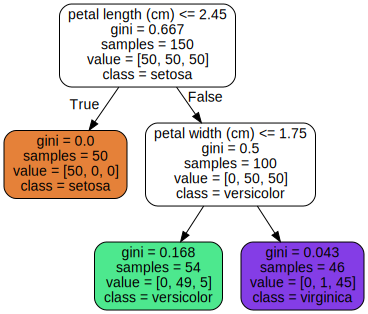

In [31]:
export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

## Make the prediction

Text(4.05, 0.5, '(Depth=2)')

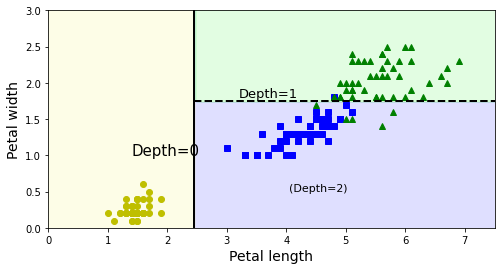

In [55]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
#plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
#plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

In [57]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X, y)

DecisionTreeClassifier()

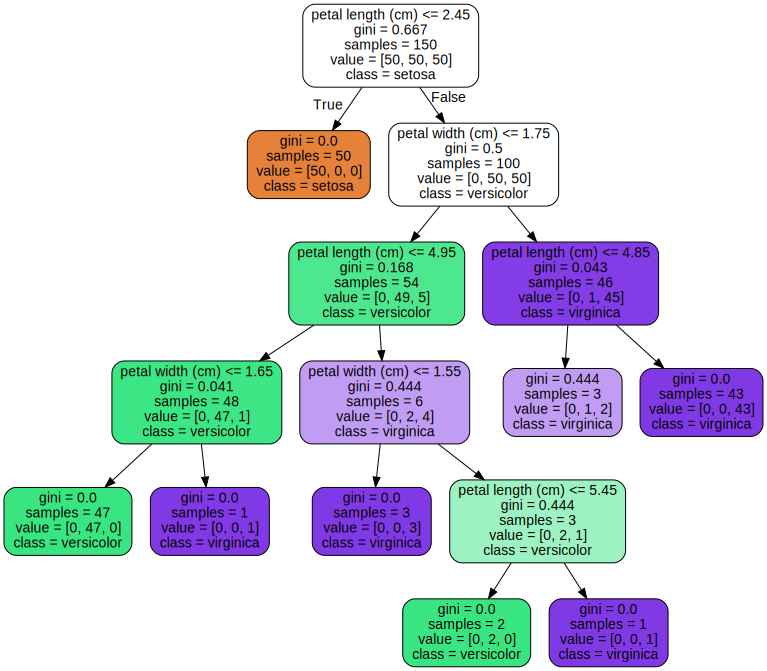

In [58]:
export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )
Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

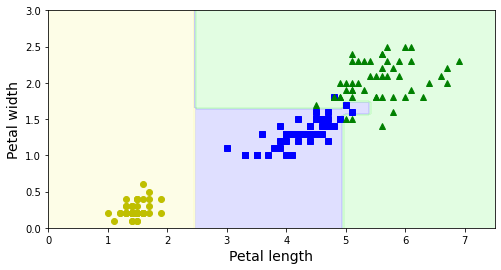

In [59]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)